## ML prediction efficacy of G, abundance, topology for disequilibrium 


In [2]:
import os
import numpy as np
import pandas as pd
import json
import sklearn.model_selection as ms
from sklearn import metrics
import xgboost as xgb
import matplotlib.pyplot as plt
import time

In [2]:
def XGB_accuracy(X, Y):
    # Split for training and testing
    x_train, x_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=0)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    # Fit the decision tree
    classifier = xgb.XGBClassifier(objective="multi:softprob", min_child_wight=10, max_depth= 5, n_estimators=1000)
    classifier = classifier.fit(x_train, y_train, early_stopping_rounds=100, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    # Predictions
    y_pred = classifier.predict(x_test)
    return metrics.accuracy_score(y_test, y_pred)

### headers for different groups of features

In [3]:
header = ["Temperature", "Metallicity Altitude",	
          "Mean Degree", "Average clustering coefficient", 
          "Average node betweenness centrality", "Edge betweenness centrality",	
          "Average shortest path length", "Average neighbor degree", 
          "CO abundance", "CH4 abundance", "NH3 abundance",	"H2O abundance",	
          "Delta G distribution",	"Phi distribution"	
          "Mean of Temperature Distribution", "Kzz", "Spread of Uncertainty"]

header_abundance = ["CO abundance", "CH4 abundance", "NH3 abundance",	"H2O abundance"]

header_topology = ["Mean Degree", "Average clustering coefficient", 
                "Average node betweenness centrality", "Edge betweenness centrality",	
                "Average shortest path length", "Average neighbor degree"]

In [ ]:
# compute accuracy of predicting Kzz using different combination of G, topoAve, and abundance.
dict_var = {'g':['Delta G distribution'],  'topo': header_topology, 'ab': header_abundance,
            'topo_ab': header_topology + header_abundance, 
            'g_topo': ['Delta G distribution'] + header_topology,
            'g_ab' : ['Delta G distribution'] + header_abundance,
            'g_topo_ab': ['Delta G distribution'] + header_topology + header_abundance}

for var in ['ab', 'topo']:#dict_var.keys():
    st = time.time()
    var_name = dict_var[var]

    dict_accuracy = dict()
    for spread in ["50", "250", "500", "1000"]: #spread
        data_dir = "/Users/hkim78/work/HotJupiter/data/atmosphere-uncertainty/parsed_data/2021/%sk_spread/"%spread
        plot_dir = "/Users/hkim78/work/HotJupiter/plot/atmosphere-uncertainty/parsed_data/2021/%sk_spread/"%spread

        dict_accuracy[spread] = list()

        for t in np.arange(400, 2100, 100):
            data0 = pd.read_csv(data_dir + 'kzz0-aveT%dK.csv'%(t))
            data1 = pd.read_csv(data_dir + 'kzz1-aveT%dK.csv'%(t))
            data2 = pd.read_csv(data_dir + 'kzz2-aveT%dK.csv'%(t))
            data3 = pd.read_csv(data_dir + 'kzz3-aveT%dK.csv'%(t))

            frames = [data0, data1, data2, data3]
            features = var_name + ['Kzz']
            allData = pd.concat(frames, ignore_index=True)

            allData = allData[features]

            # Split into dependent and independent variables
            X = allData.iloc[:, :-1]
            Y = allData.iloc[:, -1].values

            a = XGB_accuracy(X, Y)
            dict_accuracy[spread].append(a)

    result_dir = "/Users/hkim78/work/2020-hotJupiter/ML/results/accuracy/2021/"
    output_path = result_dir + "accuracy_%s.json"%var

    with open(output_path, 'w') as outfile:
        json.dump(dict_accuracy, outfile)

    et = time.time()

    print(var, (et - st))


/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20:43:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_child_wight" } are not used.



/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20:43:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_child_wight" } are not used.



/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20:43:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_child_wight" } are not used.



/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20:43:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_child_wight" } are not used.



/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/hkim78/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20:43:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "min_child_wight" } are not used.



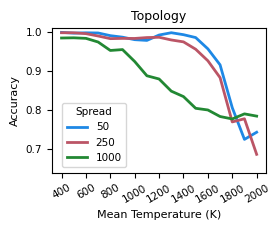

In [4]:
# individual plots with different combination of variables; G, topoAve, and abundance.
list_var = ['topo', 'ab', 'g',
            'topo_ab', 'g_topo', 'g_ab',
            'g_topo_ab']

dict_varname = {'topo': 'Topology', 'ab': 'Abundance', 'g':'G',
            'topo_ab': 'Topology + Abundance', 'g_topo':'G + Topology', 'g_ab': 'G + Abundance',
            'g_topo_ab': 'G + Topology + Abundance'}

dir_plot = "/Users/hkim78/work/HotJupiter/plot/atmosphere-uncertainty/machine_learning/"
if not os.path.exists(dir_plot):
    os.mkdir(dir_plot)

result_dir = "/Users/hkim78/work/HotJupiter/ML/results/accuracy/"

input_paths = dict()
for var in list_var[:1]:
    input_paths[var] = result_dir + 'accuracy_%s_maxdepth10.json'%var
    with open(input_paths[var]) as infile:
        a = json.load(infile)
    list_cc = ['#1E88E5', '#BB5566', '#228833']

    plt.figure(figsize=(2.9, 2.4))
    i = 0
    for spread in ["50", "250", "1000"]:
        plt.plot(a[spread], label=spread, linewidth=2, color=list_cc[i])

        plt.xticks(np.arange(0, 17, 2), np.arange(400, 2100, 200), fontsize=7.5, rotation=30)
        plt.yticks(fontsize=7.5)
        plt.xlabel("Mean Temperature (K)", fontsize=8)
        plt.ylabel("Accuracy", fontsize=8)
        i += 1

    plt.title("%s"%dict_varname[var], fontsize=9)
    plt.ylim([0.64,1.01])
    legend_spread = plt.legend(prop={"size":7.5}, title='Spread', bbox_to_anchor=(0.05, 0.22, 0.32, 0.3))
    plt.setp(legend_spread.get_title(), fontsize= 7.5)
    plt.tight_layout()
    plt.savefig(dir_plot + "accuracy_%s.png"%var, dpi=90)
    plt.show()